# Import lib

In [1]:
import os
import cv2
import math
import random
import pandas as pd 
import numpy as np
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import glob
tqdm.pandas()
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import imagehash
import PIL
import albumentations as A

# Get data

In [2]:
root_path = r"D:\Coding_practice\_Data\plant-pathology-2021-fgvc8"
train_image_path = r"D:\Coding_practice\_Data\plant-pathology-2021-fgvc8\train_images"
train_csv_path = r"D:\Coding_practice\_Data\plant-pathology-2021-fgvc8\train.csv"

train_csv = pd.read_csv(train_csv_path, index_col='image')
display(train_csv.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18632 entries, 800113bb65efe69e.jpg to fffe472a0001bd25.jpg
Data columns (total 1 columns):
labels    18632 non-null object
dtypes: object(1)
memory usage: 291.1+ KB


None

# Turn label into one-hot encoding

In [3]:
train_visualize = train_csv.copy()
classes = []

train_visualize['labels'] = [x.split(' ') for x in train_visualize['labels']]
[classes.extend(x) for x in train_visualize['labels']]
classes = list(set(classes))
print("Classes: {}".format(classes))
labels = MultiLabelBinarizer(classes=classes).fit_transform(train_visualize['labels'].values)

train_visualize = pd.DataFrame(columns=classes, data=labels, index=train_visualize.index)
# train_visualize[classes].sum()
print(f"Class percentage: \n{train_visualize[classes].mean() * 100}")
train_visualize['total_class'] = [sum(x) for x in train_visualize[classes].values]
print("There are total {} images that have multi-labels".format(len(train_visualize.iloc[np.where(train_visualize['total_class'] > 1)])))

Classes: ['healthy', 'scab', 'rust', 'frog_eye_leaf_spot', 'powdery_mildew', 'complex']
Class percentage: 
healthy               24.817518
scab                  30.656934
rust                  11.147488
frog_eye_leaf_spot    23.357664
powdery_mildew         6.821597
complex               11.544654
dtype: float64
There are total 1355 images that have multi-labels


# Check duplicate images

In [4]:
class CFG():

    threshold = .9
    img_size = 512
    seed = 42

## Downscaled image

In [5]:
paths = os.listdir(train_image_path)
train_ds_path = r"D:\Coding_practice\_Data\plant-pathology-2021-fgvc8\train_ds_images"
os.makedirs(train_ds_path, exist_ok=True)

if len(paths) == len(os.listdir(train_ds_path)):
    pass

else:
    for path in tqdm(paths, total=len(paths)):
        image = cv2.imread(os.path.join(train_image_path, path))
        image = cv2.resize(image,(CFG.img_size, CFG.img_size))
        cv2.imwrite(os.path.join(train_ds_path, path), image)

## Hash computation

In [ ]:
hash_functions = [
    imagehash.average_hash,
    imagehash.phash,
    imagehash.dhash,
    imagehash.whash,
]

hashes = []
image_ids = []

paths = os.listdir(train_ds_path)

for path in tqdm(paths, total=len(paths)):
    
    image = PIL.Image.open(os.path.join(train_ds_path,path))

    hashes.append(np.array([x(image).hash for x in hash_functions]).reshape(-1,))
    image_ids.append(path.split("\\")[-1])

hashes = np.array(hashes)
image_ids = np.array(image_ids)

## Search across hashed images for duplicate

In [ ]:
duplicate_ids = []

for i in tqdm(range(len(hashes)), total=len(hashes)):
    similarity = (hashes[i] == hashes).mean(axis=1)
    duplicate_ids.append(list(image_ids[similarity > CFG.threshold]))

duplicates = [frozenset([x] + y) for x, y in zip(image_ids, duplicate_ids)]
duplicates = set([x for x in duplicates if len(x) > 1])

print("Export duplicates to 'duplicates.csv'.")
with open(os.path.join(root_path,"duplicates.csv"), "w") as file:
    for row in duplicates:
        file.write(",".join(row) + "\n")

print(f"Found {len(duplicates)} duplicate pairs")

In [ ]:
def show_duplicates(duplicates):
    for row in duplicates:
        
        figure, axes = plt.subplots(1, len(row), figsize=[5 * len(row), 5])

        for i, image_id in enumerate(row):
            image = plt.imread(os.path.join(train_image_path, image_id))
            axes[i].imshow(image)
            
            axes[i].set_title(f"{image_id} - {train_csv.loc[image_id, 'labels']}")
            axes[i].axis("off")

        plt.show()

show_duplicates(duplicates)

# Check image augmentation

In [81]:
albumentation_list = [
    A.RandomSunFlare(p=1), 
    A.RandomFog(p=1, fog_coef_lower=0.3, fog_coef_upper=0.5, alpha_coef=0.1),
    A.RandomBrightness(p=1, limit=0.5),
    A.CoarseDropout(p=1, max_holes=8, max_height=int(CFG.img_size * 0.1), max_width=int(CFG.img_size * 0.1)),
    A.RGBShift(p=1),
    A.ChannelShuffle(p=1),
    A.RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.9, 1), p=1), 
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
    A.ShiftScaleRotate(p=1),
    A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50),
    A.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=1),
    A.CLAHE(clip_limit=(1,4), p=1),
    
    A.OpticalDistortion(distort_limit=1.0, p=1),
    A.GridDistortion(num_steps=5, distort_limit=0.7, p=1),
    A.ElasticTransform(alpha=3, p=1),

    A.GaussNoise(var_limit=[10, 50], p=1),
    A.GaussianBlur(p=1),
    A.MotionBlur(p=1),
    A.MedianBlur(p=1),

    A.JpegCompression(p=1),
    A.Downscale(scale_min=0.1, scale_max=0.15, always_apply=True, p=1),

    A.IAAPiecewiseAffine(p=1),
    A.IAASharpen(p=1),
    A.Cutout(max_h_size=int(CFG.img_size * 0.1), max_w_size=int(CFG.img_size * 0.1), num_holes=5, p=1),
]
title_list = ["Original", "RandomSunFlare","RandomFog","RandomBrightness", "CoarseDropout", "RGBShift", "ChannelShuffle", "RandomResizedCrop", "HorizontalFlip", "VerticalFlip", "ShiftScaleRotate", "HueSaturationValue", "RandomBrightnessContrast", "CLAHE", "OpticalDistortion", "GridDistortion", "ElasticTransform", "GaussNoise", "GaussianBlur", "MotionBlur", "MedianBlur", "JpegCompression", "Downscale", "IAAPiecewiseAffine", "IAASharpen", "Cutout"]

# albumentation_list = [
#     A.RandomSunFlare(p=1), 
#     A.RandomFog(p=1), 
#     A.RandomBrightness(p=1),
#     A.RandomCrop(p=1, height = 512, width = 512),
#     A.Rotate(p=1, limit=90),
#     A.RGBShift(p=1), 
#     A.RandomSnow(p=1),
#     A.HorizontalFlip(p=1), 
#     A.VerticalFlip(p=1), 
#     A.RandomContrast(limit = 0.5,p = 1),
#     A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50),
#     A.Cutout(p=1),
#     A.Transpose(p=1), 
#     A.JpegCompression(p=1),
#     A.CoarseDropout(p=1),
#     A.IAAAdditiveGaussianNoise(loc=0, scale=(2.5500000000000003, 12.75), per_channel=False, p=1),
#     A.IAAAffine(scale=1.0, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', p=1),
#     A.IAAAffine(rotate=90., p=1),
#     A.IAAAffine(rotate=180., p=1)
#     ]
# title_list = ["Original","RandomSunFlare","RandomFog","RandomBrightness", "RandomCrop","Rotate", "RGBShift", "RandomSnow","HorizontalFlip", "VerticalFlip","RandomContrast","HSV", "Cutout","Transpose","JpegCompression","CoarseDropout","IAAAdditiveGaussianNoise","IAAAffine","IAAAffineRotate90","IAAAffineRotate180"]

In [94]:
transform = A.Compose([
    A.OneOf([
        A.RGBShift(),
        A.ChannelShuffle(),
    ], p=0.2),

    A.RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.9, 1), p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
    A.CLAHE(clip_limit=(1,4), p=0.5),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=0.7),
        A.ElasticTransform(alpha=3),
    ], p=0.2),

    A.OneOf([
        A.GaussNoise(var_limit=[10, 50]),
        A.GaussianBlur(),
        A.MotionBlur(),
        A.MedianBlur(),
    ], p=0.2),

    A.OneOf([
        # A.RandomSunFlare(), 
        A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=0.5, alpha_coef=0.1),
        A.RandomBrightness(limit=0.3, p=1),
    ], p=0.2),

    A.Resize(CFG.img_size, CFG.img_size),

    A.OneOf([
        A.JpegCompression(),
        A.Downscale(scale_min=0.1, scale_max=0.15),
    ], p=0.2),

    A.IAAPiecewiseAffine(p=0.2),
    A.IAASharpen(p=0.2),
    A.Cutout(max_h_size=int(CFG.img_size * 0.1), max_w_size=int(CFG.img_size * 0.1), num_holes=5, p=0.5),

    ])

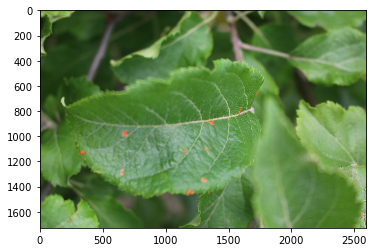

In [6]:
img_path = r"D:\Coding_practice\_Data\plant-pathology-2021-fgvc8\train_images\8a0d7cad7053f18d.jpg"
chosen_image = cv2.imread(img_path)
chosen_image = cv2.cvtColor(chosen_image, cv2.COLOR_BGR2RGB)
plt.imshow(chosen_image)

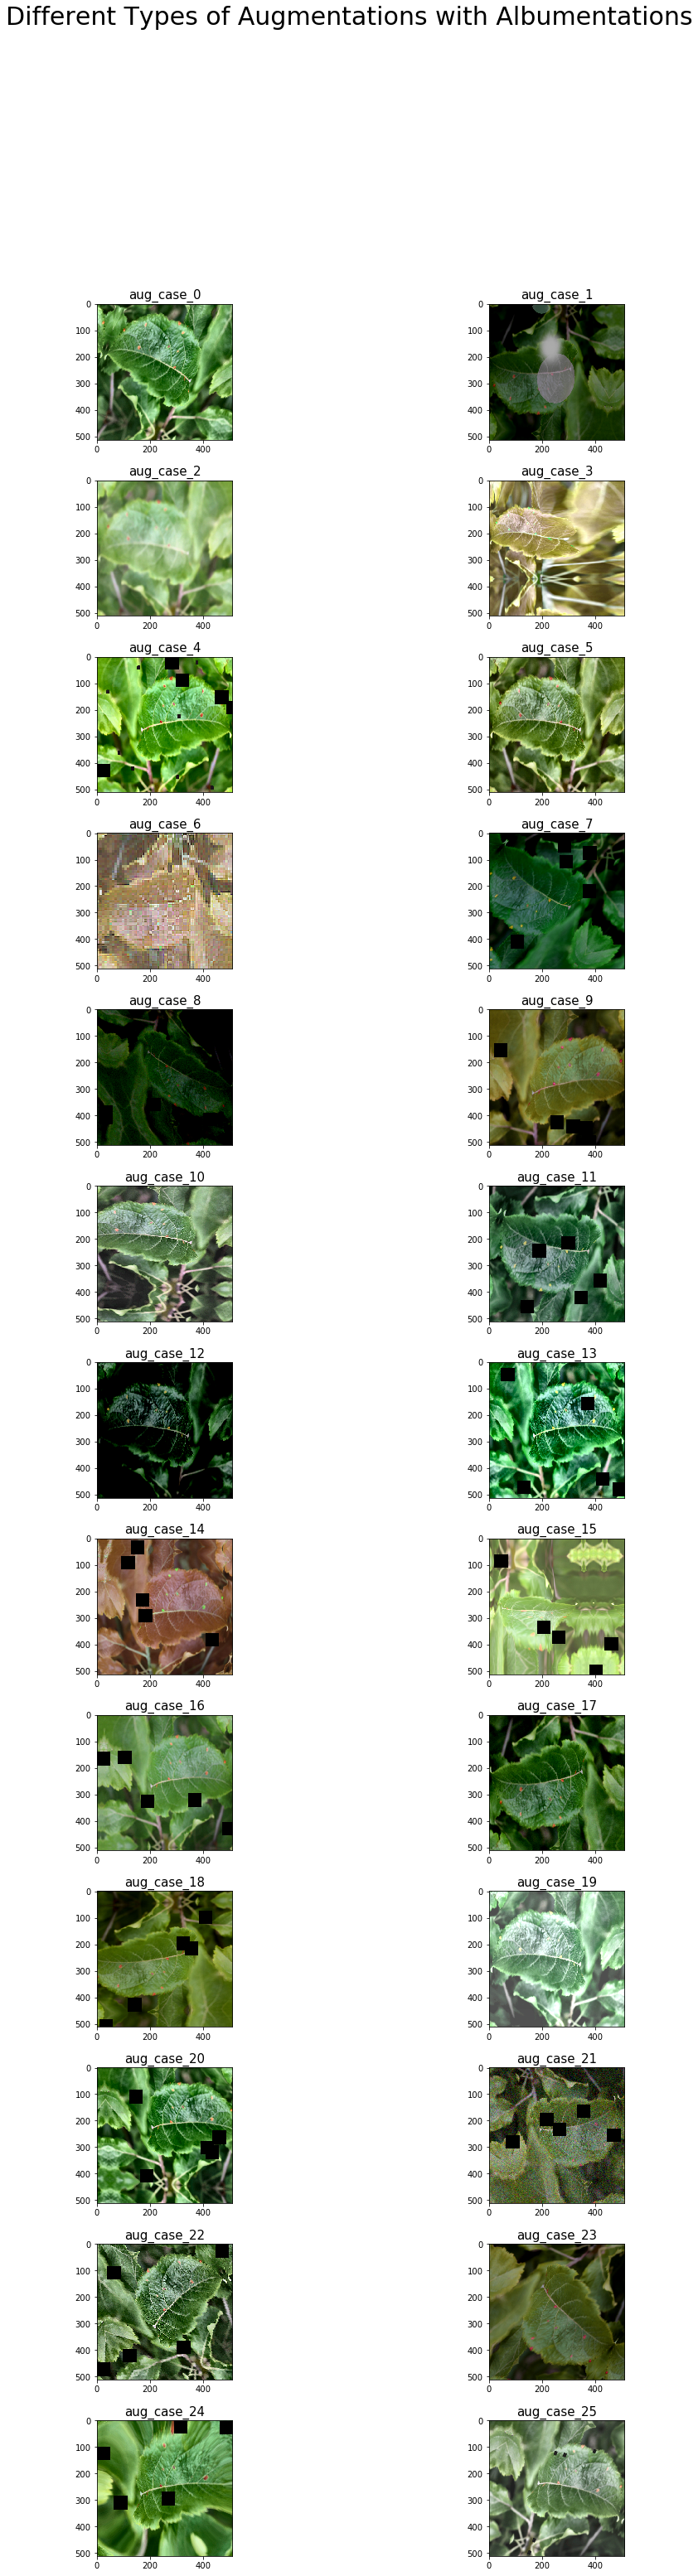

In [95]:
img_matrix_list = []
bboxes_list = []

for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0, chosen_image)

def plot_multiple_img(img_matrix_list, title_list, ncols, nrows=len(title_list) // 2, main_title="",  transform=None):

    fig, myaxes = plt.subplots(figsize=(15, 50), nrows=nrows, ncols=ncols, squeeze=False)

    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)

    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        if transform:
            myaxes[i // ncols][i % ncols].imshow(transform(image = img)['image'])

        else:
            myaxes[i // ncols][i % ncols].imshow(img)

        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)

    plt.show()

# temp_title_list = title_list
temp_title_list = [f"aug_case_{i}" for i in range(len(img_matrix_list))]

plot_multiple_img( img_matrix_list, temp_title_list, ncols=2, main_title="Different Types of Augmentations with Albumentations", 
# transform=None)
transform=transform)
